In [1]:
import gdal
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,f1_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier


In [13]:
def getBands(filename):
    img = gdal.Open(filename)
    bands = []
    for i in range(img.RasterCount):
        band = img.GetRasterBand(i+1).ReadAsArray().astype(np.float)
        bands.append(band)
    bands = np.dstack((bands[0],bands[1],bands[2],bands[3]))
    return bands
def maxminNorm(data):
    '''
    01标准化
    '''
    data=data.astype(np.float32)
    dmax=data.max()
    dmin=data.min()
    return (data-data.min())/(dmax-dmin)

def index(data,ind="NDVI"):
    '''
    input:原始数据，默认保持影像形状，默认计算NDVI
    returns:相应指数
    '''
    nir=data[:,:,3]
    red=data[:,:,2]
    grn=data[:,:,1]
    blue=data[:,:,0]
    if ind=="NDVI":# 归一化植被指数 
        NDVI=(nir-red)/(nir+red+1e-8)
        return NDVI
    elif ind=="NDWI":# 归一化水体指数
        NDWI=(grn-nir)/(grn+nir+1e-8)
        return NDWI
    elif ind=="CIg":# 叶绿素指数-绿边 
        CIg=nir/(grn+1e-8)-1
        return CIg
    elif ind=="EVI":# 增强型植被指数 
        EVI=2.5*(nir-red)/(nir+ 6*red-7.5*blue+1+1e-8)
        return EVI
    elif ind=="GNDVI":# 绿光归一化差值植被指数
        GNDVI = (nir - grn)/(nir + grn+1e-8)
        return GNDVI
    elif ind=="MSAVI":# 修正土壤调节植被指数
        MSAVI=0.5*(2*(nir +1)-np.sqrt((2*nir+1)**2-8*(nir-red)))
        return MSAVI
    elif ind=="MTVI":# 修正型三角植被指数
        MTVI=1.5*(1.2*(nir-grn)-2.5*(red-grn))/np.sqrt((2*nir+1)**2-(6*nir-5*np.sqrt(red))-0.5)
        return MTVI
    elif ind=="SAVI":# 土壤调节植被指数
        L=0.5
        SAVI=((nir-red)/(nir+red+L))*(1+L)
        return SAVI
    elif ind=="VARI":# 可视化大气阻抗指数
        VARI=(grn-red)/(grn+red-blue+1e-8)
        return VARI
    
def returnLabeldata(data,indexName,df=False,reshape=True,norm=False):
    h,w,d=data.shape
    dataIdx=np.zeros((data.shape[0],data.shape[1],len(indexName)),dtype=np.float32)
    for i,idx in enumerate(indexName):
        if norm==True:
            dataIdx[:,:,i]=maxminNorm(index(data,ind=idx))
        else:
            dataIdx[:,:,i]=index(data,ind=idx)
    if len(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))!=0:
        print(np.unique(np.argwhere(np.isnan(dataIdx))[:,2]))
    if df==True:
        res=pd.DataFrame(dataIdx.reshape((h*w,-1)),columns=indexName)
    if reshape==True:
        res=dataIdx.reshape((h*w,-1))
    else:
        res=dataIdx
    return res

def addY(loc,data,nums):#data3维
    loc=loc.astype(np.int)
    y=np.array([0]*nums[0]+[1]*nums[1]+[2]*nums[2]+[3]*nums[3]+[4]*nums[4]).reshape((sum(nums),1))
    x=np.zeros((sum(nums),data.shape[2]))
    for i,yx in enumerate(loc):
        x[i,:]=data[yx[1],yx[0],:]
    train=np.concatenate((x,y),axis=1)
    return train

def cotrain(datadf,x1,y1,x2,y2,model1,model2,size=50):
    model1.fit(x1,y1.ravel())
    model2.fit(x2,y2.ravel())
    # 候选预测数据概率和标签
    datadf['prob1']=model1.predict_proba(datadf[features1]).max(axis=1)
    datadf['prob2']=model2.predict_proba(datadf[features2]).max(axis=1)
    datadf['guessClass1']=model1.predict(datadf[features1])
    datadf['guessClass2']=model2.predict(datadf[features2])
    # 找到guessclass一致区域的数据
    datadf_candidate=datadf[datadf['change1']==0][datadf['guessClass1']==datadf['guessClass2']]
    # 标签一致区域找到置信度最高的区域
    class_candidate=[datadf_candidate[datadf_candidate['guessClass1']==i] for i in range(5)]
    # 找到两期置信度都高的区域更新训练集
    sizes=[size,size//2,size//3,size//2,size//10]
    for i in range(5):
        index1=np.array(class_candidate[i].sort_values(by="prob1" , ascending=False).index)
        index2=np.array(class_candidate[i].sort_values(by="prob2" , ascending=False).index)
        can1=index1[:sizes[i]]
        can2=index2[:sizes[i]]
#         for id1 in index1:
#             if id1 in index2[:int(index2.shape[0]*0.05)]:
#                 can1.append(id1)
#             if len(can1)==sizes[i]//2:
#                 break
#         for id2 in index2:
#             if id2 in index1[:int(index1.shape[0]*0.05)]:
#                 can2.append(id2)
#             if len(can2)==sizes[i]//2:
#                 break
#        canid=np.array(can1+can2)
        x1=np.concatenate((x1,class_candidate[i].loc[can1,features1]),axis=0)
        x2=np.concatenate((x2,class_candidate[i].loc[can2,features2]),axis=0)
        y1=np.concatenate((y1,class_candidate[i].loc[can1,['guessClass1']].values.reshape((-1,1))),axis=0)
        y2=np.concatenate((y2,class_candidate[i].loc[can2,['guessClass2']].values.reshape((-1,1))),axis=0)
    return x1,y1,x2,y2,model1,model2

def run(datadf,x1,y1,x2,y2,model1,model2,x_test1,y_test1,x_test2,y_test2,size=50,epoch=20):
    score1,score2=[],[]
    for i in range(epoch):
        x1,y1,x2,y2,model1,model2=cotrain(datadf,x1,y1,x2,y2,model1,model2,size)
        y_pre1 = model1.predict(x_test1)
        y_pre2 = model2.predict(x_test2)
        f1=f1_score(y_test1, y_pre1, average='weighted')
        f2=f1_score(y_test2, y_pre2, average='weighted')
        print("%.5f %.5f"%(f1,f2))
        score1.append(f1)
        score2.append(f2)
    return model1,model2,score1,score2

def color(y_pred):
    y_pred=y_pred.reshape((400,400))
    show=np.zeros((400,400,3))
    cmap=np.array([[0,255,0],[255,255,0],[0,0,255],[255,0,0],[0,255,255]])
    for i in range(5):
        show[y_pred==i,:]=cmap[i]
    return show

In [14]:
# prepare data
path=r"E:\project\images\researchImage\HR\originData"
img1=getBands(os.path.join(path,"000326.tif"))
img2=getBands(os.path.join(path,"040121.tif"))
data1=img1[600:1000,600:1000,:]
data2=img2[600:1000,600:1000,:]
indexName=["NDVI","NDWI","MSAVI","MTVI","VARI"]
labdata1=returnLabeldata(data1,indexName,reshape=False,norm=True)
labdata2=returnLabeldata(data2,indexName,reshape=False,norm=True)
data1norm=maxminNorm(data1)
data2norm=maxminNorm(data2)
data1total=np.concatenate((data1norm,labdata1),axis=2)
data2total=np.concatenate((data2norm,labdata2),axis=2)

In [15]:
# load label
label1=np.loadtxt(open(r"E:\project\images\researchImage\HR\label\train00.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
label2=np.loadtxt(open(r"E:\project\images\researchImage\HR\label\train04.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
loc1=label1[:,:2]
loc2=label2[:,:2]
train1=addY(loc1,data1total,[200,200,200,200,100])
train2=addY(loc2,data2total,[200,200,200,200,100])

In [16]:
# prepare mask
mask=cv2.imread(r"E:\project\images\researchImage\HR\label\mask.tif",0)
unmask=cv2.imread(r"E:\project\images\researchImage\HR\label\unmask.tif",0)
mask=mask.ravel()
unmask=unmask.ravel()
data1reshape=data1total.reshape((-1,data1total.shape[2]))
data2reshape=data2total.reshape((-1,data2total.shape[2]))

In [17]:
#初始化数据
features1=['blue1','grn1','red1','nir1','NDVI1','NDWI1','MSAVI1','MTVI1','VARI1']
features2=['blue2','grn2','red2','nir2','NDVI2','NDWI2','MSAVI2','MTVI2','VARI2']
data00df=pd.DataFrame(data1reshape,columns=features1)
data04df=pd.DataFrame(data2reshape,columns=features2)
data00df['change1']=unmask
data04df['change2']=unmask
data00df['row1']=np.array([i//400 for i in range(data00df.shape[0])])
data00df['col1']=np.array([i%400 for i in range(data00df.shape[0])])
data04df['row2']=np.array([i//400 for i in range(data04df.shape[0])])
data04df['col2']=np.array([i%400 for i in range(data04df.shape[0])])
data00df['prob1']=np.zeros((data00df.shape[0]))
data04df['prob2']=np.zeros((data04df.shape[0]))
data00df['guessClass1']=np.zeros((data00df.shape[0]))-1
data04df['guessClass2']=np.zeros((data00df.shape[0]))-1
data00df['acceptClass1']=np.zeros((data00df.shape[0]))-1
data04df['acceptClass2']=np.zeros((data00df.shape[0]))-1
datadf=pd.concat([data00df,data04df],axis=1)

In [18]:
# 准备数据
x1=train1[:,:-1]
y1=train1[:,-1:]
x2=train2[:,:-1]
y2=train2[:,-1:]

In [19]:
# load label
lab1=np.loadtxt(open(r"E:\project\images\researchImage\HR\label\test00.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
lab2=np.loadtxt(open(r"E:\project\images\researchImage\HR\label\test04.csv","r"),delimiter=',',skiprows=25,dtype=np.int)
testloc1=lab1[:,:2]
testloc2=lab2[:,:2]
test1=addY(testloc1,data1total,[1724,1344,1585,1964,1210])
test2=addY(testloc2,data2total,[2070,1024,1049,1185,127])
x_test1 = test1[:,:-1]
y_test1 = test1[:,-1]
x_test2 = test2[:,:-1]
y_test2 = test2[:,-1]

In [20]:
# 构造model训练
RFS1=RandomForestClassifier(n_estimators=50)
GBC1=GradientBoostingClassifier(n_estimators=50)
model1=VotingClassifier(estimators=[("rfs_clf", RFS1),("gbc_clf", GBC1)],voting='soft')
RFS2=RandomForestClassifier(n_estimators=50)
GBC2=GradientBoostingClassifier(n_estimators=50)
model2=VotingClassifier(estimators=[("rfs_clf", RFS2),("gbc_clf", GBC2)],voting='soft')
model1,model2,score1,score2=run(datadf,x1,y1,x2,y2,model1,model2,x_test1,y_test1,x_test2,y_test2,size=50,epoch=20)

d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.79007 0.89928


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78889 0.89699


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.79050 0.89586


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.79361 0.89512


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78808 0.89485


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78825 0.89376


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78822 0.89409


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78560 0.89557


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78415 0.89373


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78911 0.89245


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78511 0.89366


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78750 0.89450


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78498 0.89319


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78428 0.89284


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78346 0.89397


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78817 0.89380


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78747 0.89313


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78813 0.89182


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.79099 0.89185


d:\python37\lib\site-packages\ipykernel_launcher.py:92: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.78947 0.89182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 399.5, 399.5, -0.5)

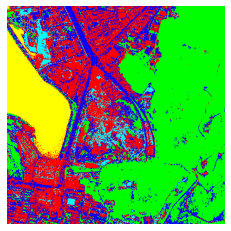

In [21]:
y_pred1=model1.predict(data1reshape).astype(np.int)
show1=color(y_pred1)
cv2.imwrite(r"E:\project\images\researchImage\HR\output\epoch20size50class00.jpg",show1)
plt.imshow(show1)
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 399.5, 399.5, -0.5)

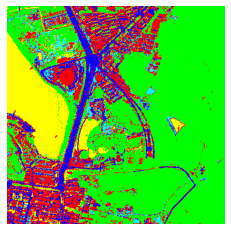

In [22]:
y_pred2=model2.predict(data2reshape).astype(np.int)
show2=color(y_pred2)
cv2.imwrite(r"E:\project\images\researchImage\HR\output\epoch20size50class04.jpg",show2)
plt.imshow(show2)
plt.axis('off')

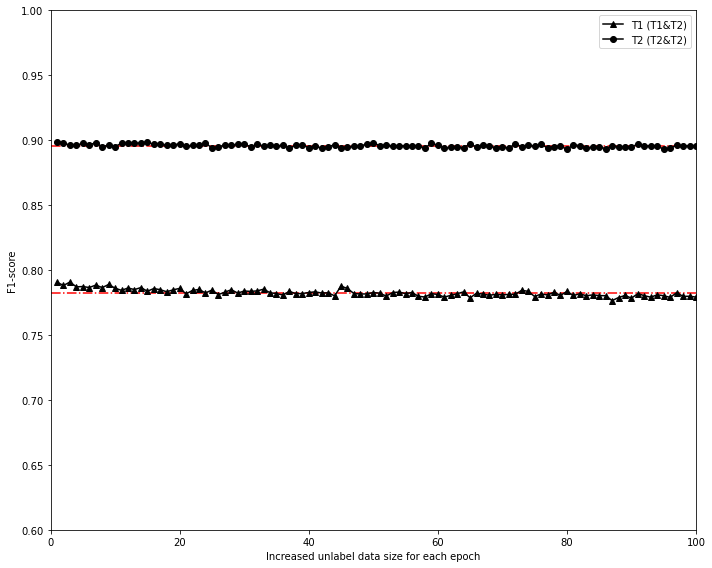

In [49]:
epochs=list(range(1,101))
plt.figure(figsize=(10,8))
plt.plot(epochs,score1,color='black',marker='^',linestyle='-')
plt.plot(epochs,score2,color='black',marker='o',linestyle='-')
# plt.plot(epochs,score1,color='black',marker='^',linestyle='--')
# plt.plot(epochs,score2,color='black',marker='o',linestyle='--')
f1m=np.array(score1).mean()
f2m=np.array(score2).mean()
plt.hlines(f1m, 0, 100, colors = "red", linestyles = "-.")
plt.hlines(f2m, 0, 100, colors = "r", linestyles = "-.")
plt.ylim(0.6,1)
plt.xlim(0,100)
plt.ylabel('F1-score')
plt.xlabel("Increased unlabel data size for each epoch")
plt.legend(['T1 (T1&T2)','T2 (T2&T2)'])
plt.tight_layout()
plt.savefig(r"E:\project\images\researchImage\HR\output\f1scoreSize10Epoch100.jpg")
plt.show()